In [28]:
# Imports
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, precision_recall_curve

sns.set(style='whitegrid')

# Paths
models_dir = os.path.abspath(os.path.join('..', 'models'))
print('Looking for models in:', models_dir)
model_files = {
    'GB': 'gb_calibrated.joblib',
    'XGB': 'xgb_calibrated.joblib',
    'LR': 'log_calibrated.joblib',
    'RF': 'rf_calibrated.joblib'
}
loaded_models = {}
for name, fname in model_files.items():
    path = os.path.join(models_dir, fname)
    if os.path.exists(path):
        try:
            loaded_models[name] = joblib.load(path)
            print(f'Loaded {name} from {path}')
        except Exception as e:
            print(f'Failed to load {path}:', e)
    else:
        print(f'Model file not found: {path}')

# Load data (train-derived provider dataset)
train_path = os.path.abspath(os.path.join('..','data','processed','Train_final.csv'))
if not os.path.exists(train_path):
    raise FileNotFoundError(f'Training data not found at {train_path} - ensure data is present')
train_df = pd.read_csv(train_path)

# Prepare features and target (same columns as modeling notebook)
X = train_df.drop(columns=['Provider', 'PotentialFraud'])
y = train_df['PotentialFraud']

# Recreate same split as modeling notebooks (stratified split)
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print('Data split sizes:')
print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)

Looking for models in: c:\Users\omarh\Fraud Detection\HealthCare-Insurance-Fraud-Detection\models
Loaded GB from c:\Users\omarh\Fraud Detection\HealthCare-Insurance-Fraud-Detection\models\gb_calibrated.joblib
Loaded XGB from c:\Users\omarh\Fraud Detection\HealthCare-Insurance-Fraud-Detection\models\xgb_calibrated.joblib
Loaded LR from c:\Users\omarh\Fraud Detection\HealthCare-Insurance-Fraud-Detection\models\log_calibrated.joblib
Loaded RF from c:\Users\omarh\Fraud Detection\HealthCare-Insurance-Fraud-Detection\models\rf_calibrated.joblib
Data split sizes:
Train: (4328, 38) Val: (541, 38) Test: (541, 38)


In [29]:
def evaluate_with_threshold(model_name, y_true, y_probs, threshold):
    """Evaluate model with explicit threshold and print full metrics."""

    # Convert probabilities to labels
    y_pred = (y_probs >= threshold).astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_probs)
    avg_precision = average_precision_score(y_true, y_probs)
    cm = confusion_matrix(y_true, y_pred)

    print(f"{model_name} @ threshold={threshold:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}, AP: {avg_precision:.4f}")
    print("Confusion matrix:")
    print(cm)

    return {
        "model": model_name,
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "avg_precision": avg_precision
    }


In [30]:
def best_precision_with_minimum_recall(y_true, prob, target_recall=0.92, steps=2000):
    thresholds = np.linspace(0, 1, steps)
    best_thresh, best_prec, best_rec = 0.0, 0.0, 0.0
    for t in thresholds:
        preds = (prob >= t).astype(int)
        prec = precision_score(y_true, preds, zero_division=0)
        rec = recall_score(y_true, preds)
        if rec >= target_recall and prec > best_prec:
            best_prec, best_rec, best_thresh = prec, rec, t
    return best_thresh, best_prec, best_rec

In [31]:
def best_precision_with_minimum_recall(y_true, prob, target_recall=0.92):
    thresholds = np.linspace(0, 1, 2000)
    best_thresh, best_prec, best_rec = 0, 0, 0

    for t in thresholds:
        preds = (prob >= t).astype(int)
        prec = precision_score(y_true, preds, zero_division=0)
        rec = recall_score(y_true, preds)

        if rec >= target_recall and prec > best_prec:
            best_prec = prec
            best_rec = rec
            best_thresh = t

    return best_thresh, best_prec, best_rec


In [32]:
# Evaluate all models on validation set
def find_threshold_for_recall(y_true, y_probs, target_recall=0.90):
    """Find the highest threshold that still achieves >= target_recall."""
    prec, rec, thresh = precision_recall_curve(y_true, y_probs)
    valid_idx = np.where(rec >= target_recall)[0]
    if len(valid_idx) == 0:
        return 0.0
    best_idx = min(valid_idx[-1], len(thresh) - 1)
    return thresh[best_idx]


print("="*70)
print("MODEL EVALUATION ON VALIDATION SET")
print("="*70)

results = []

for model_name, model_obj in loaded_models.items():

    print("\n" + "="*70)
    print(f"Evaluating: {model_name}")
    print("="*70)

    # Predict probabilities
    val_probs = model_obj.predict_proba(X_val)[:, 1]

    # Find threshold based on rules
    if model_name == 'RF':
        threshold = find_threshold_for_recall(y_val, val_probs, target_recall=0.90)
        target_recall = 0.90
    else:
        threshold, _, _ = best_precision_with_minimum_recall(
            y_val, val_probs, target_recall=0.92
        )
        target_recall = 0.92

    # Evaluate the model with chosen threshold
    result = evaluate_with_threshold(model_name, y_val, val_probs, threshold)
    results.append(result)

    print(f"Target Recall: >= {target_recall}")


# Summary table
print("\n" + "="*70)
print("SUMMARY: ALL MODELS ON VALIDATION SET")
print("="*70)

summary_df = pd.DataFrame([
    {
        'Model': r['model'],
        'Threshold': r['threshold'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1'],
        'ROC-AUC': r['roc_auc'],
        'Avg Precision': r['avg_precision']
    }
    for r in results
])

print(summary_df.to_string(index=False))


MODEL EVALUATION ON VALIDATION SET

Evaluating: GB
GB @ threshold=0.6208
Precision: 0.5341, Recall: 0.9216, F1: 0.6763, ROC AUC: 0.9661, AP: 0.7071
Confusion matrix:
[[449  41]
 [  4  47]]
Target Recall: >= 0.92

Evaluating: XGB
XGB @ threshold=0.5653
Precision: 0.5402, Recall: 0.9216, F1: 0.6812, ROC AUC: 0.9635, AP: 0.6970
Confusion matrix:
[[450  40]
 [  4  47]]
Target Recall: >= 0.92

Evaluating: LR
LR @ threshold=0.3092
Precision: 0.3013, Recall: 0.9216, F1: 0.4541, ROC AUC: 0.9459, AP: 0.7336
Confusion matrix:
[[381 109]
 [  4  47]]
Target Recall: >= 0.92

Evaluating: RF
RF @ threshold=0.2014
Precision: 0.5750, Recall: 0.9020, F1: 0.7023, ROC AUC: 0.9677, AP: 0.7381
Confusion matrix:
[[456  34]
 [  5  46]]
Target Recall: >= 0.9

SUMMARY: ALL MODELS ON VALIDATION SET
Model  Threshold  Precision   Recall       F1  ROC-AUC  Avg Precision
   GB   0.620810   0.534091 0.921569 0.676259 0.966086       0.707051
  XGB   0.565283   0.540230 0.921569 0.681159 0.963505       0.696972
   LR  

## FINAL MODEL: Random Forest with best params

In [34]:

# Get RF model and threshold from results
rf_model = loaded_models['RF']
rf_result = [r for r in results if r['model'] == 'RF'][0]
rf_threshold = rf_result['threshold']

print("=" * 50)
print("FINAL MODEL EVALUATION ON TEST SET")
print("=" * 50)
print(f"\nUsing RF threshold from validation: {rf_threshold:.4f}")

# Get test probabilities
test_probs = rf_model.predict_proba(X_test)[:, 1]

# Evaluate on test set
test_result = evaluate_with_threshold("Random Forest (Final - Test)", y_test, test_probs, rf_threshold)

print("\n" + "=" * 50)
print("TEST SET RESULTS")
print("=" * 50)
print(f"Threshold (from validation): {rf_threshold:.4f}")
print(f"Test Precision: {test_result['precision']:.4f}")
print(f"Test Recall: {test_result['recall']:.4f}")
print(f"Test F1: {test_result['f1']:.4f}")
print(f"Test ROC AUC: {test_result['roc_auc']:.4f}")
print(f"Test AP: {test_result['avg_precision']:.4f}")

FINAL MODEL EVALUATION ON TEST SET

Using RF threshold from validation: 0.2014
Random Forest (Final - Test) @ threshold=0.2014
Precision: 0.5114, Recall: 0.9000, F1: 0.6522, ROC AUC: 0.9722, AP: 0.8370
Confusion matrix:
[[448  43]
 [  5  45]]

TEST SET RESULTS
Threshold (from validation): 0.2014
Test Precision: 0.5114
Test Recall: 0.9000
Test F1: 0.6522
Test ROC AUC: 0.9722
Test AP: 0.8370


CONFUSION MATRICES AND COST ANALYSIS


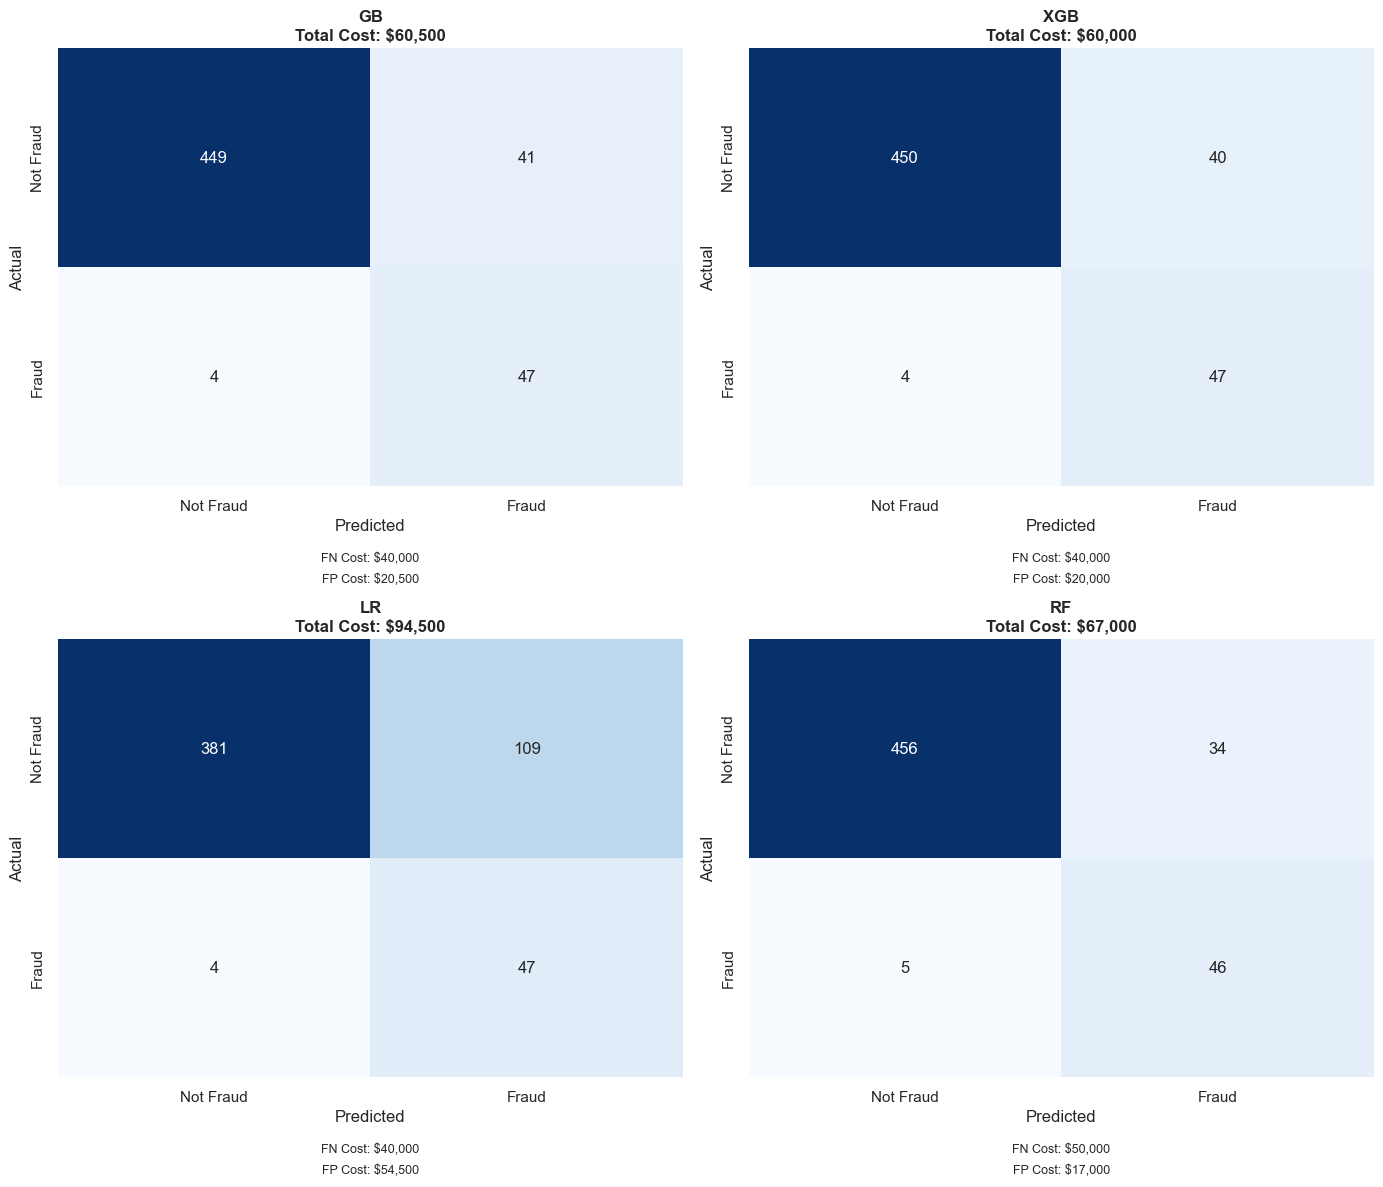


COST ANALYSIS SUMMARY
Model  TN  FP  FN  TP  FP_Cost  FN_Cost  Total_Cost
   GB 449  41   4  47    20500    40000       60500
  XGB 450  40   4  47    20000    40000       60000
   LR 381 109   4  47    54500    40000       94500
   RF 456  34   5  46    17000    50000       67000


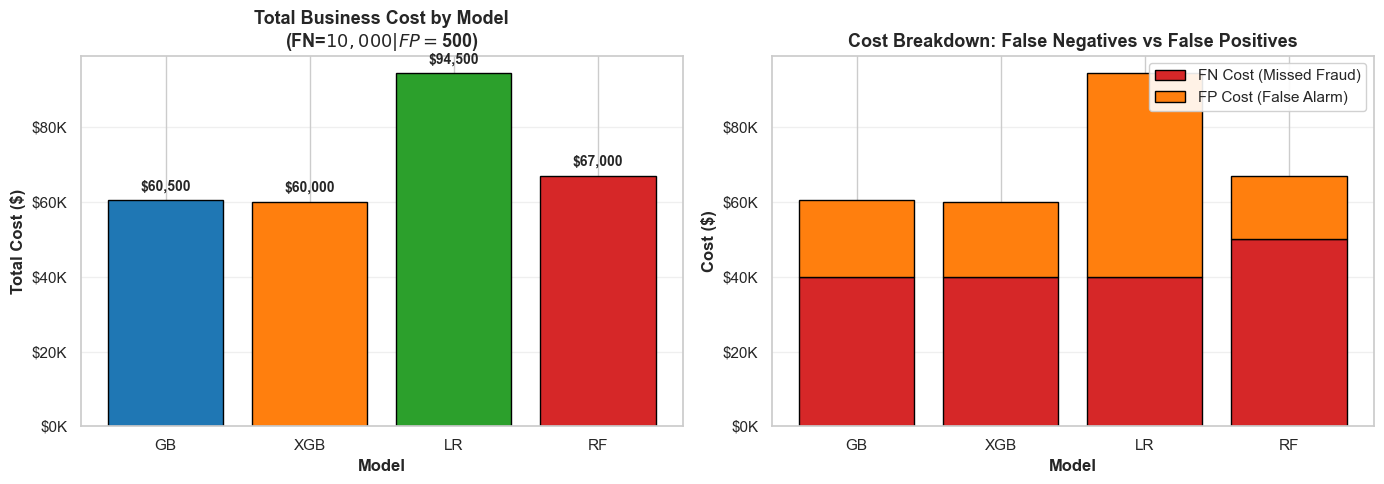


BUSINESS INSIGHTS

Lowest Cost Model: XGB
  - Total Cost: $60,000
  - False Negatives: 4 (cost: $40,000)
  - False Positives: 40 (cost: $20,000)

Cost savings vs worst model: $34,500

Diagrams saved to: ../reports/confusion_matrices.png and ../reports/cost_analysis.png


In [36]:
# Confusion Matrix and Cost-Based Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Cost parameters
COST_FN = 10000  # Cost of missing fraud (false negative)
COST_FP = 500    # Cost of false alarm (false positive)

print("="*70)
print("CONFUSION MATRICES AND COST ANALYSIS")
print("="*70)

# Create subplots for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

cost_summary = []

for idx, result in enumerate(results):
    model_name = result['model']
    
    # Get the model and make predictions
    model = loaded_models[model_name]
    val_probs = model.predict_proba(X_val)[:, 1]
    val_preds = (val_probs >= result['threshold']).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(y_val, val_preds)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate costs
    total_cost = (fn * COST_FN) + (fp * COST_FP)
    
    cost_summary.append({
        'Model': model_name,
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn),
        'TP': int(tp),
        'FP_Cost': int(fp * COST_FP),
        'FN_Cost': int(fn * COST_FN),
        'Total_Cost': int(total_cost)
    })
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'],
                ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{model_name}\nTotal Cost: ${total_cost:,}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Add cost annotations
    axes[idx].text(0.5, -0.15, f'FN Cost: ${fn * COST_FN:,}', 
                   ha='center', va='top', transform=axes[idx].transAxes, fontsize=9)
    axes[idx].text(0.5, -0.20, f'FP Cost: ${fp * COST_FP:,}', 
                   ha='center', va='top', transform=axes[idx].transAxes, fontsize=9)

plt.tight_layout()
plt.savefig('../reports/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Cost comparison table
print("\n" + "="*70)
print("COST ANALYSIS SUMMARY")
print("="*70)
cost_df = pd.DataFrame(cost_summary)
print(cost_df.to_string(index=False))

# Cost breakdown visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Total cost by model
models = cost_df['Model'].values
total_costs = cost_df['Total_Cost'].values
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

ax1.bar(models, total_costs, color=colors, edgecolor='black')
ax1.set_ylabel('Total Cost ($)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_title('Total Business Cost by Model\n(FN=$10,000 | FP=$500)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Format y-axis as currency
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add value labels on bars
for i, (model, cost) in enumerate(zip(models, total_costs)):
    ax1.text(i, cost + max(total_costs)*0.02, f'${cost:,}', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

# Stacked bar: FP vs FN cost breakdown
fp_costs = cost_df['FP_Cost'].values
fn_costs = cost_df['FN_Cost'].values

ax2.bar(models, fn_costs, label='FN Cost (Missed Fraud)', color='#d62728', edgecolor='black')
ax2.bar(models, fp_costs, bottom=fn_costs, label='FP Cost (False Alarm)', color='#ff7f0e', edgecolor='black')

ax2.set_ylabel('Cost ($)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Model', fontsize=12, fontweight='bold')
ax2.set_title('Cost Breakdown: False Negatives vs False Positives', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', framealpha=0.9)
ax2.grid(axis='y', alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.savefig('../reports/cost_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("BUSINESS INSIGHTS")
print("="*70)
best_model_idx = cost_df['Total_Cost'].idxmin()
best_model = cost_df.loc[best_model_idx]
print(f"\nLowest Cost Model: {best_model['Model']}")
print(f"  - Total Cost: ${best_model['Total_Cost']:,}")
print(f"  - False Negatives: {best_model['FN']} (cost: ${best_model['FN_Cost']:,})")
print(f"  - False Positives: {best_model['FP']} (cost: ${best_model['FP_Cost']:,})")
print(f"\nCost savings vs worst model: ${cost_df['Total_Cost'].max() - best_model['Total_Cost']:,}")
print("\nDiagrams saved to: ../reports/confusion_matrices.png and ../reports/cost_analysis.png")

In [43]:
# ERROR ANALYSIS: Understanding Model Limitations

# Extract RF model and threshold (best performing model)
rf_model = loaded_models['RF']
rf_result = [r for r in results if r['model'] == 'RF'][0]
rf_threshold = rf_result['threshold']

# Get predictions on validation set
rf_probs = rf_model.predict_proba(X_val)[:, 1]
rf_preds = (rf_probs >= rf_threshold).astype(int)

# Create dataframe with features, predictions, and actual labels
analysis_df = X_val.copy()
analysis_df["y_true"] = y_val.values
analysis_df["y_pred"] = rf_preds
analysis_df["fraud_prob"] = rf_probs

# Identify error cases
false_positives = analysis_df[(analysis_df["y_pred"] == 1) & (analysis_df["y_true"] == 0)]
false_negatives = analysis_df[(analysis_df["y_pred"] == 0) & (analysis_df["y_true"] == 1)]

print(f"\nModel: Random Forest (Best Performer)")
print(f"Threshold: {rf_threshold:.4f}")
print(f"\nTotal False Positives: {len(false_positives)} (Legitimate flagged as fraud)")
print(f"Total False Negatives: {len(false_negatives)} (Fraudulent missed)")

# Case Study 1: FALSE POSITIVES

if len(false_positives) >= 3:
    # Get diverse samples: highest confidence, medium, lowest (borderline)
    fp_sorted = false_positives.sort_values('fraud_prob', ascending=False)
    fp_samples = pd.concat([
        fp_sorted.head(1),
        fp_sorted.iloc[[len(fp_sorted)//2]],
        fp_sorted.tail(1)
    ])
else:
    fp_samples = false_positives.sample(n=min(3, len(false_positives)), random_state=42)

if len(false_negatives) >= 3:
    # Get diverse samples: lowest probability (most missed), medium, highest (borderline)
    fn_sorted = false_negatives.sort_values('fraud_prob', ascending=True)
    fn_samples = pd.concat([
        fn_sorted.head(1),
        fn_sorted.iloc[[len(fn_sorted)//2]],
        fn_sorted.tail(1)
    ])
else:
    fn_samples = false_negatives.sample(n=min(3, len(false_negatives)), random_state=42)

# Save samples
print("\n" + "="*80)
fp_samples.to_csv("../data/processed/false_positives_sample.csv", index=True)
fn_samples.to_csv("../data/processed/false_negatives_sample.csv", index=True)
print("Error samples saved to ../data/processed/")
print("="*80)


Model: Random Forest (Best Performer)
Threshold: 0.2014

Total False Positives: 34 (Legitimate flagged as fraud)
Total False Negatives: 5 (Fraudulent missed)

Error samples saved to ../data/processed/
